<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test: when is penalty needed and how large

Here we study two possible overfitting scenarios: uninformative genes and redundant states

In [35]:
import time
import pickle
%cd ..
from MC_functions import *
from EM_functions import *
%cd tests

/home/mffang/workspace/RNAV/Poisson-regression
/home/mffang/workspace/RNAV/Poisson-regression/tests


## EM_functions.py

## Utiliy functions

In [37]:
def plot_t(weight,ax=None,t=None):
    m=np.shape(weight)[1]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if t is not None:
        ord=np.argsort(t)
        # build a rectangle in axes coords
        left, width = .25, .5
        bottom, height = .25, .5
        right = left + width
        top = bottom + height
       
        ax.imshow(weight[ord,:],aspect="auto");
        ax.text(right, top,"cor="+str(np.around(np.corrcoef(t_hat,t)[0,1],2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="white");
    else:
        ord=np.argsort(t_hat)
        ax.imshow(weight[ord,:],aspect="auto");

def plot_theta(theta,theta_hat):
    K=np.shape(theta)[1]-4
    fig, ax = plt.subplots(1,K+4,figsize=(6*(K+4),4))

    for i in range(K):
        ax[i].plot(theta[:,i],theta[:,i]);
        ax[i].plot(theta[:,i],theta_hat[:,i],'.');
        ax[i].set_title("a"+str(i+1))
        ax[i].set_xlabel("true values")

    ax[-4].plot(theta[:,-4],theta[:,-4]);
    ax[-4].plot(theta[:,-4],theta_hat[:,-4],'.');
    ax[-4].set_title("u0")
    ax[-4].set_ylabel("fitted values")
    ax[-4].set_xlabel("true values")

    ax[-3].plot(theta[:,-3],theta[:,-3]);
    ax[-3].plot(theta[:,-3],theta_hat[:,-3],'.');
    ax[-3].set_title("s0")
    ax[-3].set_ylabel("fitted values")
    ax[-3].set_xlabel("true values")

    ax[-2].plot(theta[:,-2],theta[:,-2]);
    ax[-2].plot(theta[:,-2],theta_hat[:,-2],'.');
    ax[-2].set_title("beta");
    ax[-2].set_xlabel("true values");

    ax[-1].plot(theta[:,-1],theta[:,-1]);
    ax[-1].plot(theta[:,-1],theta_hat[:,-1],'.');
    ax[-1].set_title("gamma");
    ax[-1].set_xlabel("true values");
    
    for i in range(K+4):
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')


def plot_theta_hat(theta_hat,K,gene_list):
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))

    for i in range(K+4):
        ax[i].scatter(np.array(gene_list), np.log(theta_hat[:,i]));

    ax[0].set_title("log a1");
    ax[1].set_title("log a2");
    ax[2].set_title("log u0");
    ax[3].set_title("log s0");
    ax[4].set_title("log beta");
    ax[5].set_title("log gamma");


def plot_y(X,theta,theta_hat,weight,tau,true_tau=None, gene_list=None):
    if true_tau is None:
        true_tau=tau
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    if gene_list is None:
        gene_list = [""]*p
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    y = get_Y(theta, t_hat, true_tau)
    fig, ax = plt.subplots(2,p,figsize=(6*p,8))
    for i in range(p):
        ax[0,i].plot(t_hat,X[:,i,0],'.',color="gray");
        ax[0,i].plot(t_hat,y_hat[:,i,0],'b.', label = 'fit');
        ax[0,i].plot(t_hat,y[:,i,0],'r.',label = 'true');


        ax[1,i].plot(t_hat,X[:,i,1],'.',color="gray");
        ax[1,i].plot(t_hat,y_hat[:,i,1],'b.', label = 'fit');
        ax[1,i].plot(t_hat,y[:,i,1],'r.', label = 'true');
        ax[1,i].legend()



In [38]:
def get_fit_result(n=1500, rs=[0.01, 1/30, 0.1], warm=True, add_null=True, tau=None, relative_penalty=0, loga_max=4, logb_max=2, seeds=[42, 63], cores=20):
    true_tau=(0,0.5,1)
    if tau is None:
        tau = true_tau
    K=len(true_tau)-1
    t = np.linspace(0, 1, n)

    m=int(n/10)
    weight0=np.ones((n,m))
    if warm:
        weight0[int(n/2):,int(m/2):] += 0.1
    weight0 = weight0/weight0.sum(axis=1,keepdims=True)
    
    #fig, axs = plt.subplots(len(rs), K+4+len(seeds), figsize=(6*(K+4+len(seeds)),4*len(rs)))
    thetas=[]
    theta_hats=[]
    weights=[]
    
    for i,r in enumerate(rs): 
        true_p = int(n*r)  
        if add_null:
            p = 2*true_p
        else:
            p = true_p

        for j,seed in enumerate(seeds):
            np.random.seed(seed)
            theta=np.zeros((p,K+4))
            theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,1]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-4]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-2]=np.exp(np.random.uniform(0,logb_max,size=p))
            theta[:,-1]=np.exp(np.random.uniform(0,logb_max,size=p))
            theta[true_p:,-2]=1
            theta[true_p:,-1]=theta[true_p:,-4]/theta[true_p:,-3]
            theta[true_p:,0]=theta[true_p:,-4]
            theta[true_p:,1]=theta[true_p:,-4]

            thetas.append(theta)
            
            Y = get_Y(theta,t,true_tau)
            X = np.random.poisson(Y)

            theta_hat_hist, weight_hist = traj_EM(X, tau, weight0, relative_penalty=relative_penalty, epoch=20, parallel = True, n_threads = min(cores,p))
            theta_hat = theta_hat_hist[-1]
            theta_hats.append(theta_hat)
            weight=weight_hist[-1]
            weights.append(weight)
    
    return thetas, theta_hats, weights


In [39]:
def plot_uninformative_genes(thetas, theta_hats, weights, n=1500,rs=[0.01, 1/30, 0.1],seeds=[42,63],K=2):
    fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
    binwidth = 0.2
    for i in range(len(rs)):
        true_p = int(n*rs[i])  
        p = 2*true_p
        for j in range(len(seeds)):
            idx=i*len(seeds)+j
            theta=thetas[idx]
            theta_hat=theta_hats[idx]
            weight=weights[idx]
            for k in range(K):
                data = theta_hat[true_p:,k]-theta_hat[true_p:,(k-1) % (K+1)]
                axs[i,k].hist(data, bins=np.arange(min(data)-0.5*binwidth, max(data) + 0.5*binwidth, binwidth),alpha=0.3,label="#zero="+str(int(np.sum(data<1e-3))))
                axs[i,k].legend()
                
            axs[i,K].loglog(1+theta[true_p:,K],1+theta_hat[true_p:,K],'.')
            axs[i,K].loglog(1+theta[true_p:,K],1+theta[true_p:,K],'k')
            axs[i,K+1].loglog(1+theta[true_p:,K+1],1+theta_hat[true_p:,K+1],'.')
            axs[i,K+1].loglog(1+theta[true_p:,K+1],1+theta[true_p:,K+1],'k')


            axs[i,K+2].loglog(theta[true_p:,K+2],theta_hat[true_p:,K+2],'.')
            axs[i,K+2].loglog(theta[true_p:,K+2],theta[true_p:,K+2],'k')
            axs[i,K+3].loglog(theta[true_p:,K+3],theta_hat[true_p:,K+3],'.')
            axs[i,K+3].loglog(theta[true_p:,K+3],theta[true_p:,K+3],'k')


        # add title
        axs[0,0].set_title("a0 - u0");  
        axs[0,1].set_title("a1 - a0");  

        axs[0,K].set_title("log u0");
        axs[0,K+1].set_title("log s0");

        axs[0,K+2].set_title("log beta");
        axs[0,K+3].set_title("log gamma");


In [40]:
def plot_informative_genes(thetas, theta_hats, weights, n=1500,rs=[0.01, 1/30, 0.1],seeds=[42,63],K=2):
    fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
    for i in range(len(rs)):
        true_p = int(n*rs[i])  
        p = 2*true_p
        for j in range(len(seeds)):
            idx=i*len(seeds)+j
            theta=thetas[idx]
            theta_hat=theta_hats[idx]
            weight=weights[idx]
            for k in range(K+4):
                axs[i,k].loglog(theta[:true_p,k],theta_hat[:true_p,k],'.')
                axs[i,k].loglog(theta[:true_p,k],theta[:true_p,k],'k')
            
    # add title
    for k in range(K):
        axs[0,k].set_title("log a"+str(k));    
            
    axs[0,K].set_title("log u0");
    axs[0,K+1].set_title("log s0");
    
    axs[0,K+2].set_title("log beta");
    axs[0,K+3].set_title("log gamma");
    

## Redundant states

In [132]:
thetas_, theta_hats_, weights_ = get_fit_result(add_null=False, tau=(0,0.33,0.67,1))

100%|██████████| 20/20 [06:29<00:00, 19.47s/it]


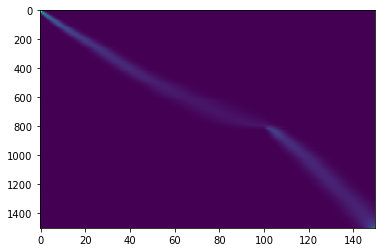

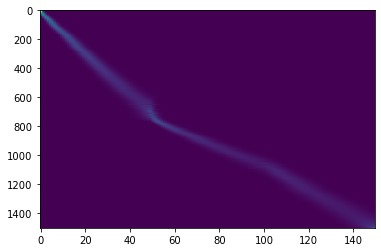

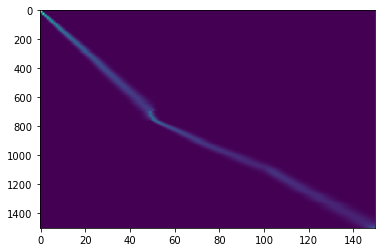

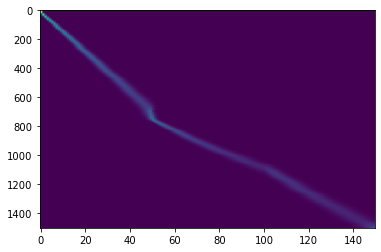

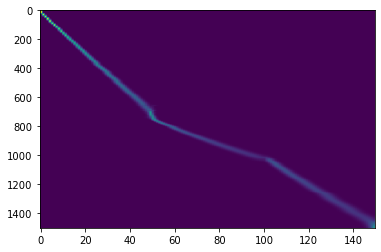

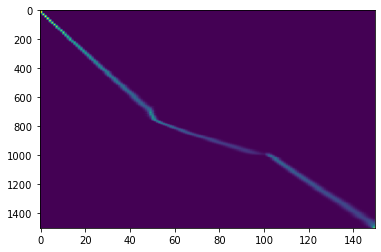

In [164]:
for idx in range(len(weights_)):
    plot_t(weights_[idx])

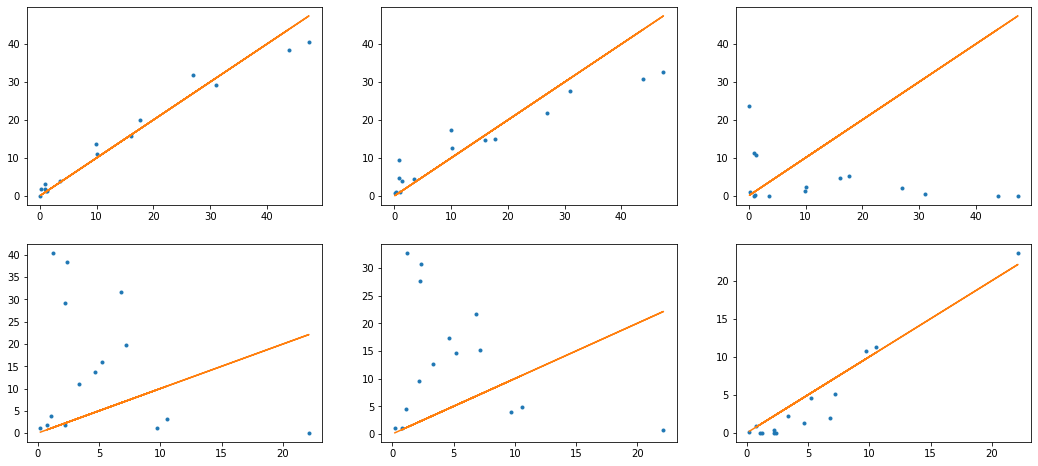

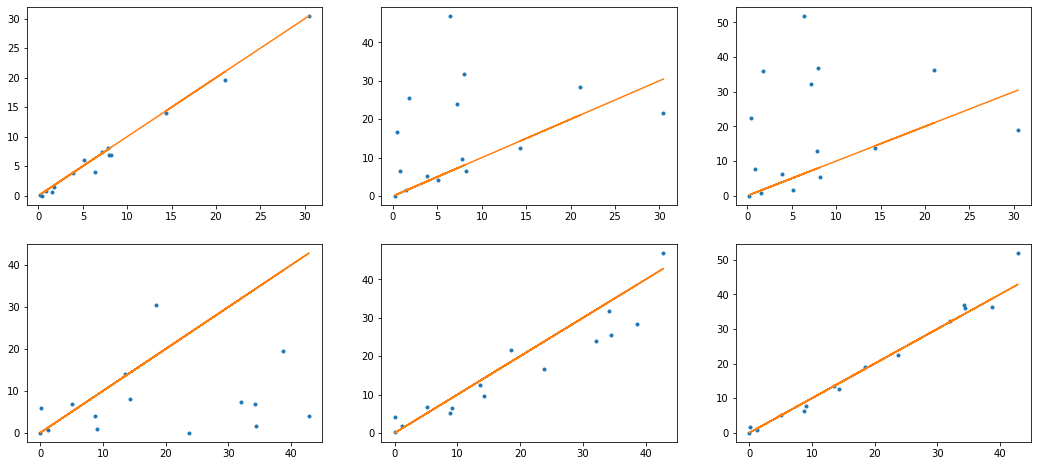

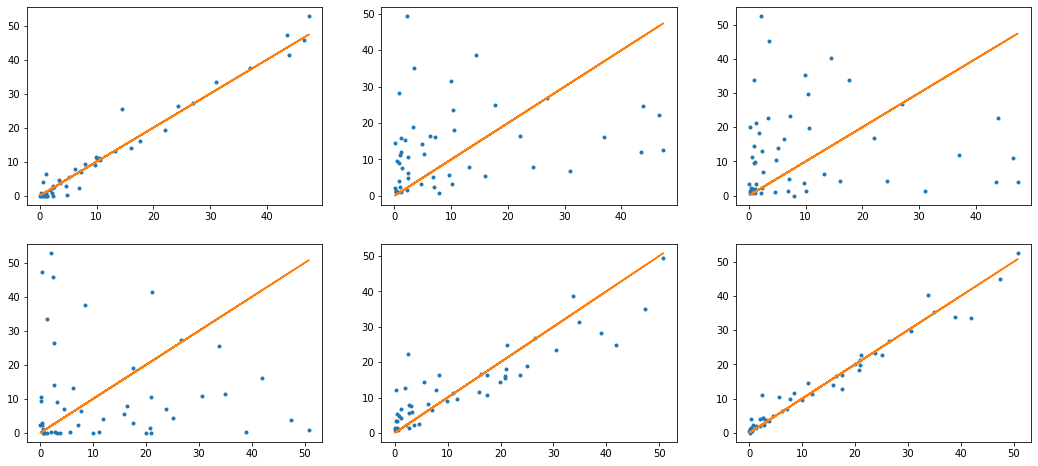

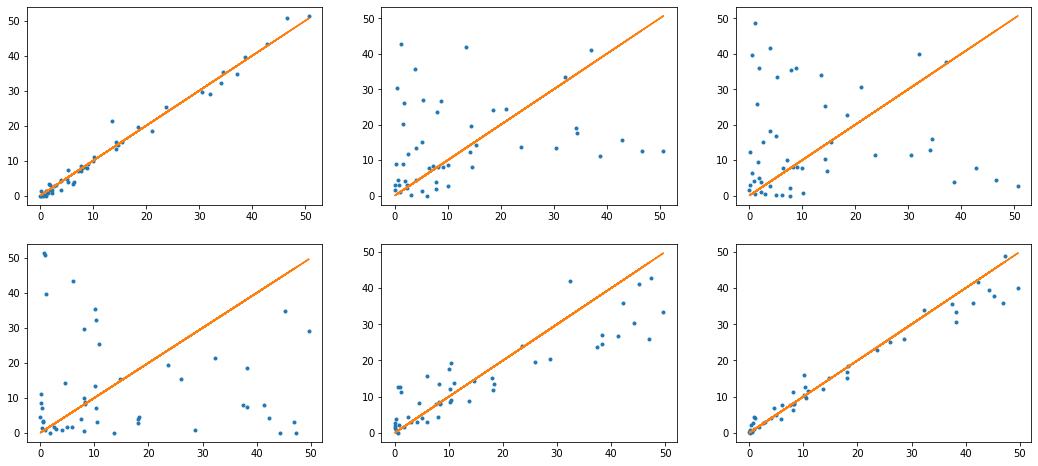

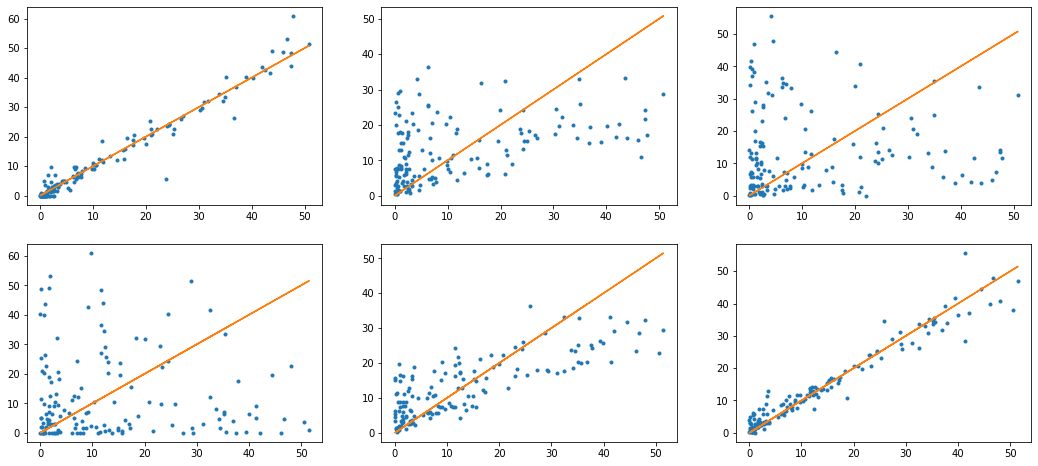

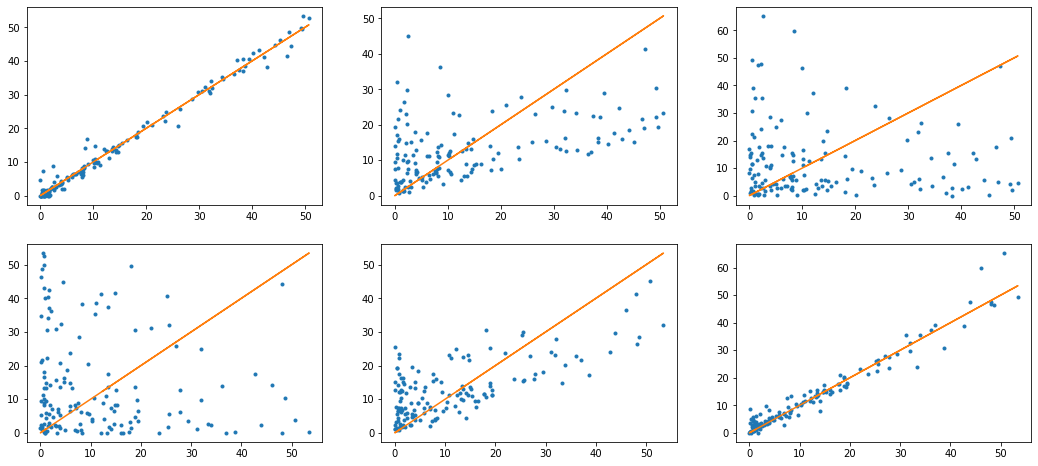

In [157]:
for idx in range(len(weights_)):
    theta = thetas_[idx]
    theta_hat = theta_hats_[idx]
    weight = weights_[idx]
    fig, ax = plt.subplots(2,3,figsize=(6*3,4*2))
    for i in range(2):
        for j in range(3):
            ax[i,j].plot(theta[:,i],theta_hat[:,j],'.')
            ax[i,j].plot(theta[:,i],theta[:,i])

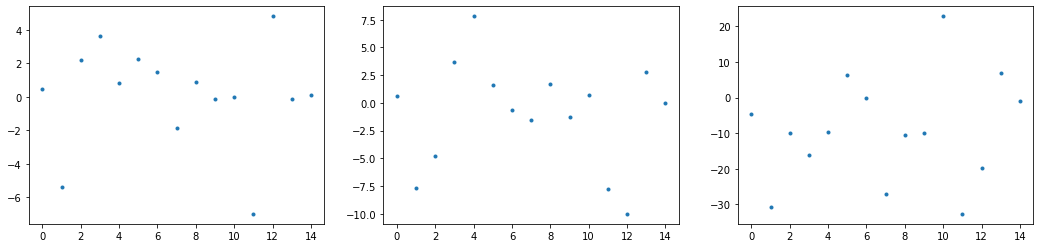

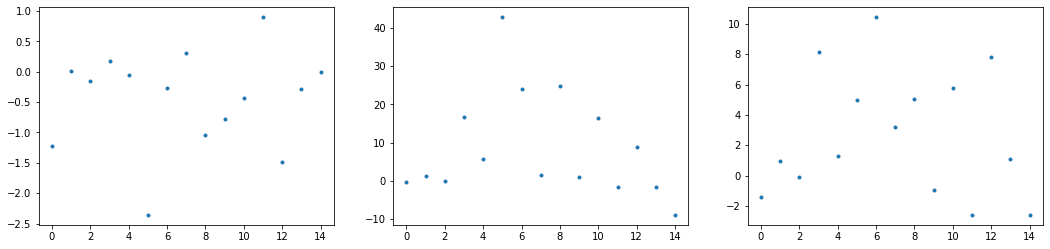

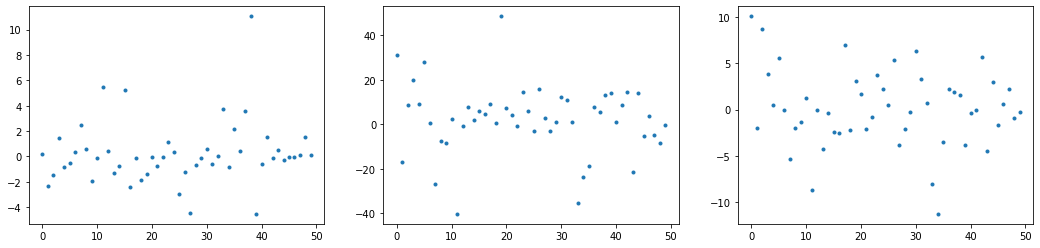

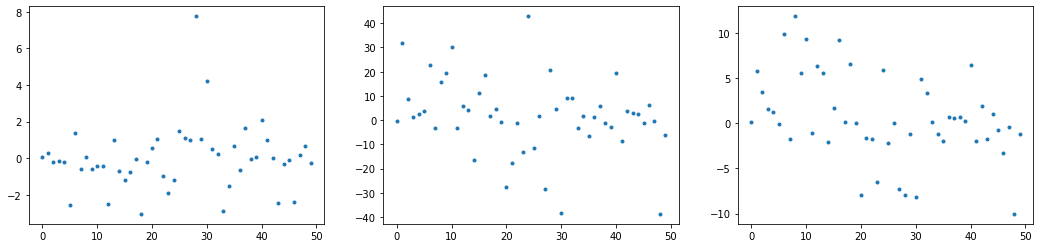

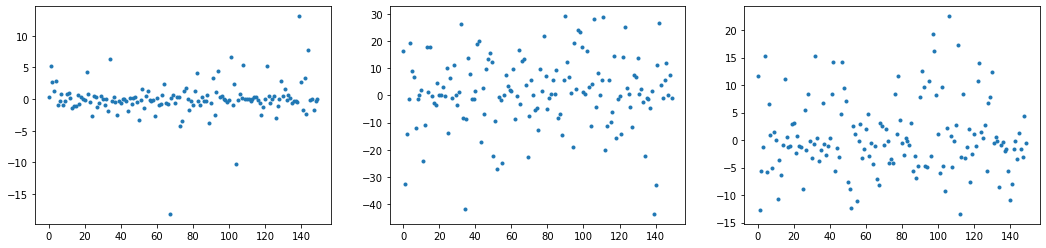

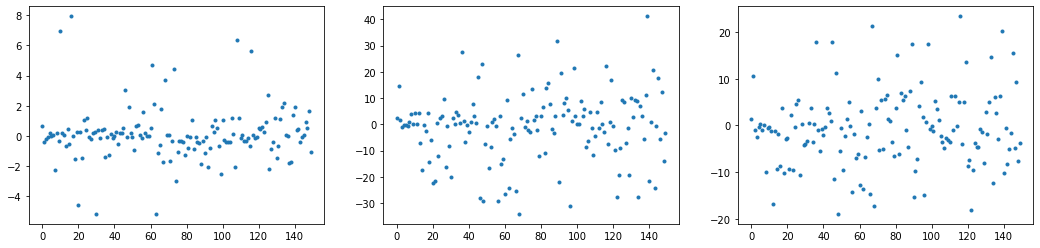

In [173]:
for idx in range(len(weights_)):
    theta = thetas_[idx]
    theta_hat = theta_hats_[idx]
    weight = weights_[idx]
    fig, ax = plt.subplots(1,3,figsize=(6*3,4))
    ax[0].plot(theta_hat[:,0]-theta[:,0],'.')
    for i in range(1,3):
        ax[i].plot(theta_hat[:,i]-theta_hat[:,i-1],'.')

In [161]:
thetas_p, theta_hats_p, weights_p = get_fit_result(add_null=False, relative_penalty=0.001, tau=(0,0.33,0.67,1))

100%|██████████| 20/20 [06:58<00:00, 20.95s/it]


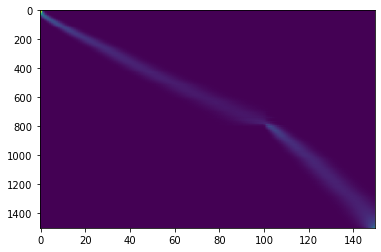

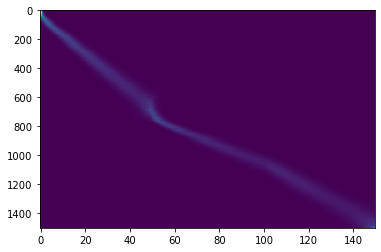

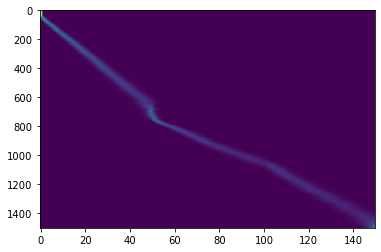

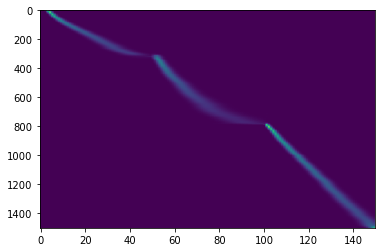

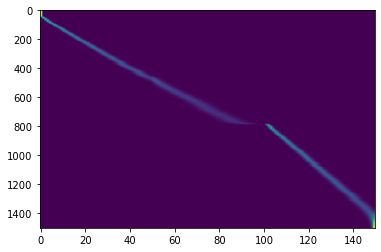

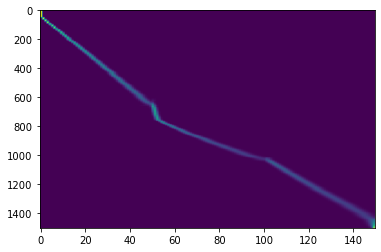

In [166]:
for idx in range(len(weights_p)):
    plot_t(weights_p[idx])

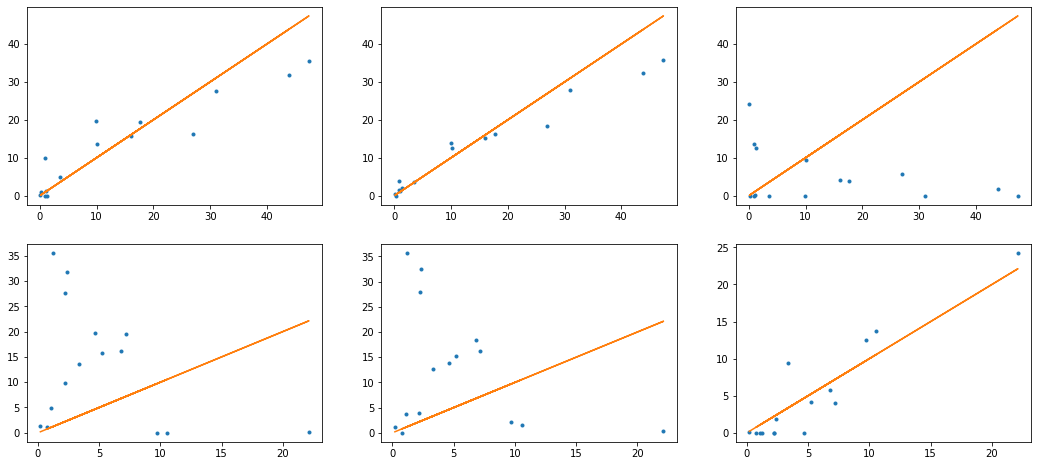

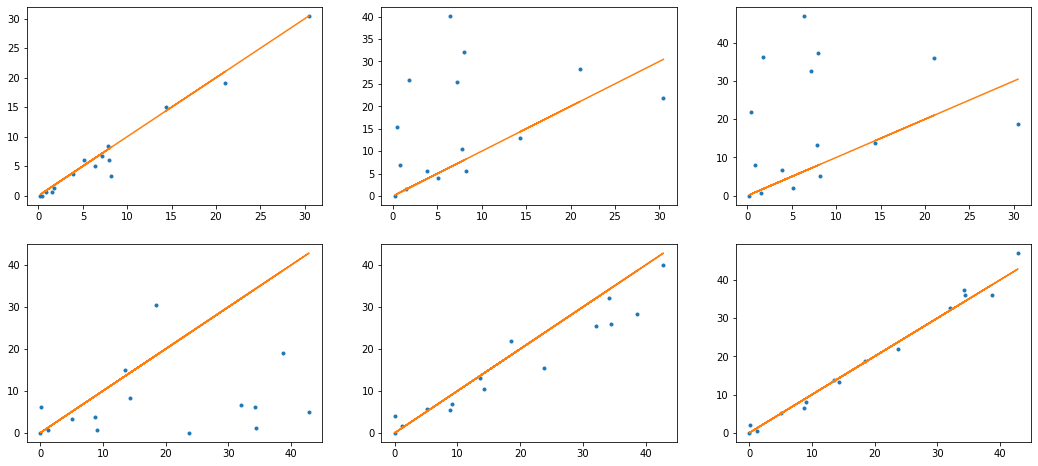

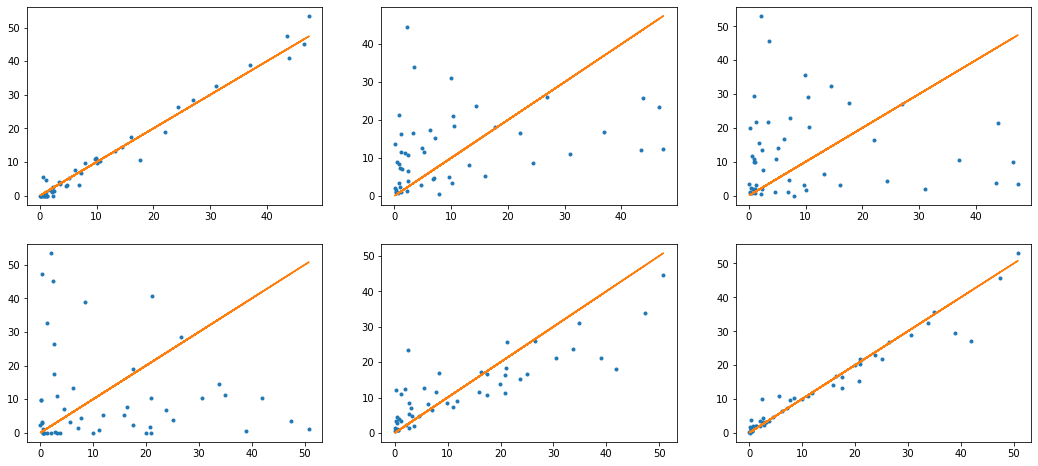

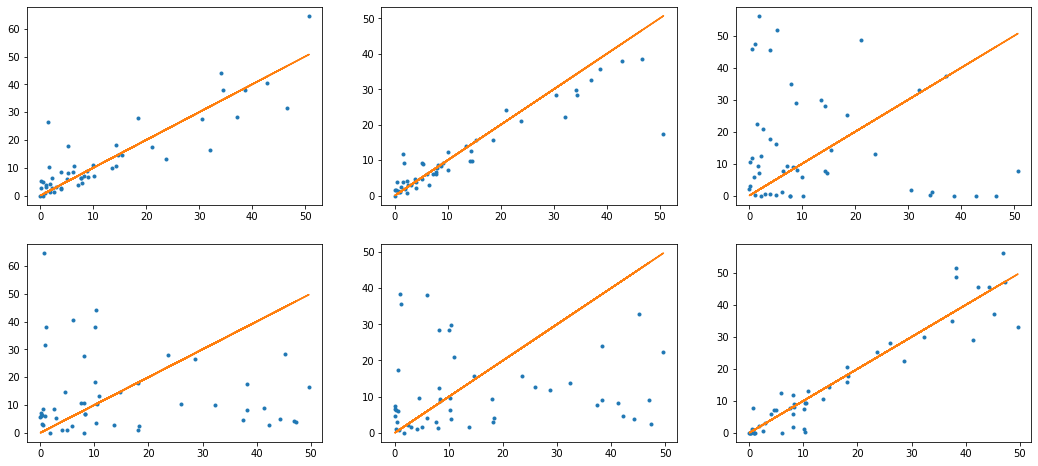

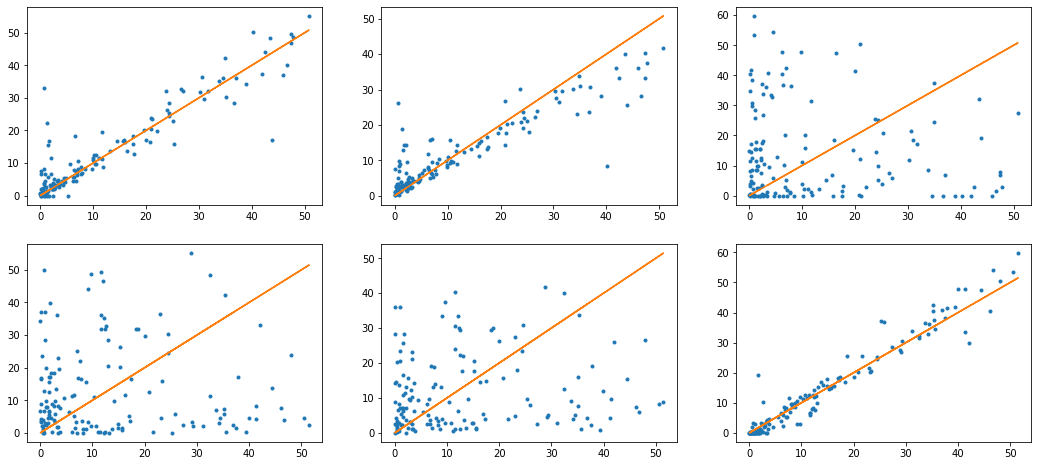

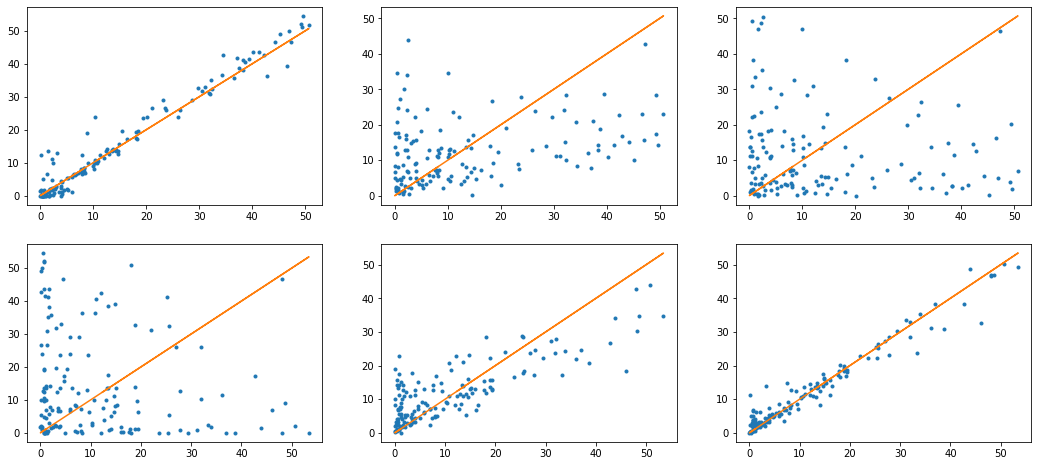

In [167]:
for idx in range(len(weights_p)):
    theta = thetas_p[idx]
    theta_hat = theta_hats_p[idx]
    weight = weights_p[idx]
    fig, ax = plt.subplots(2,3,figsize=(6*3,4*2))
    for i in range(2):
        for j in range(3):
            ax[i,j].plot(theta[:,i],theta_hat[:,j],'.')
            ax[i,j].plot(theta[:,i],theta[:,i])

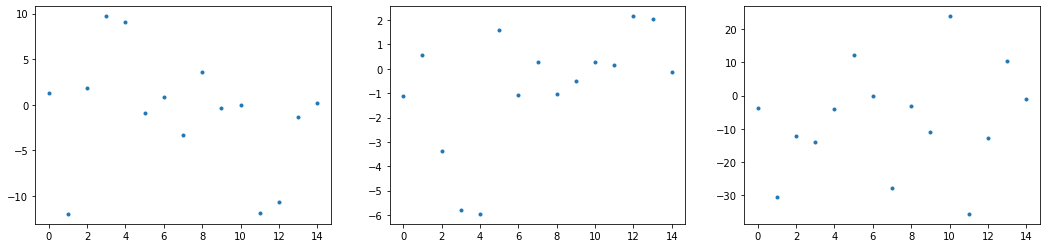

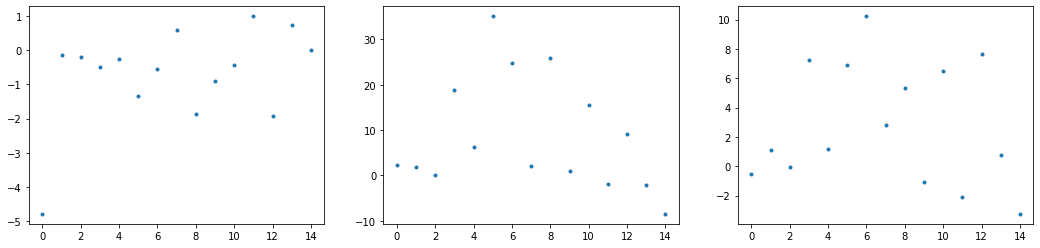

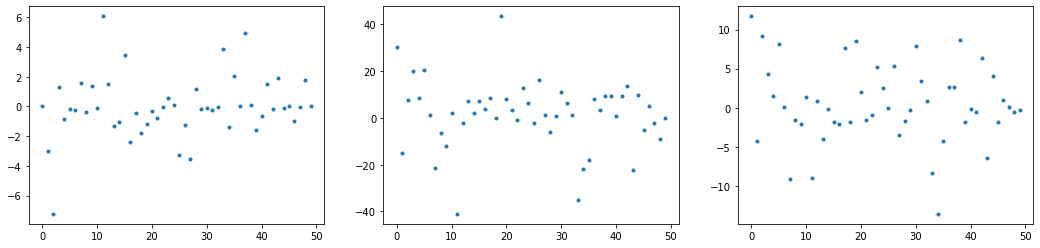

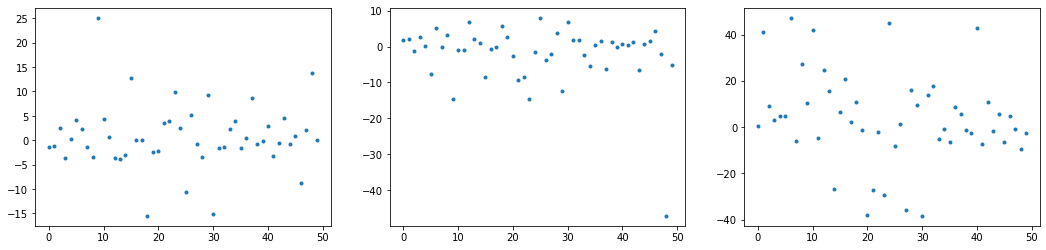

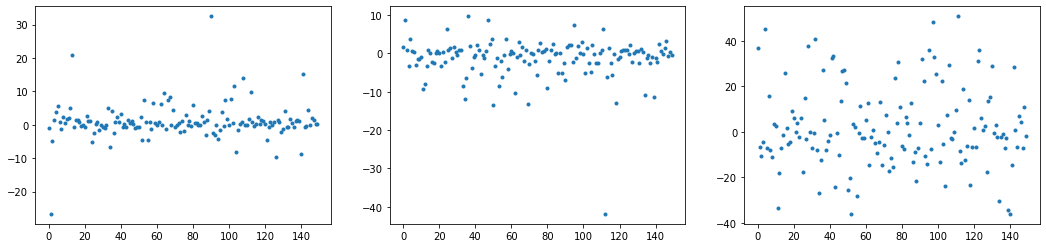

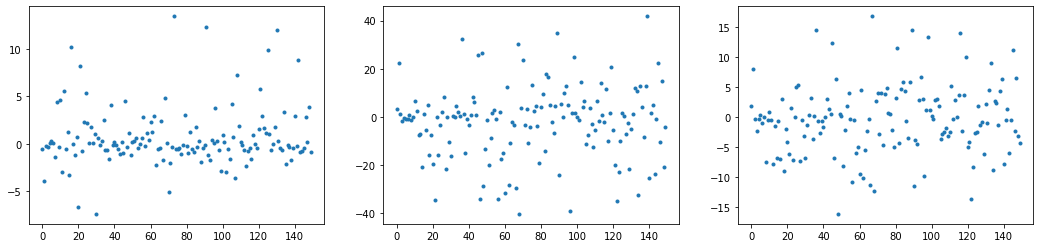

In [172]:
for idx in range(len(weights_)):
    theta = thetas_p[idx]
    theta_hat = theta_hats_p[idx]
    weight = weights_p[idx]
    fig, ax = plt.subplots(1,3,figsize=(6*3,4))
    ax[0].plot(theta_hat[:,0]-theta[:,0],'.')
    for i in range(1,3):
        ax[i].plot(theta_hat[:,i]-theta_hat[:,i-1],'.')

In [162]:
data = {0:(thetas_, theta_hats_, weights_),0.001:(thetas_p, theta_hats_p, weights_p)}
with open('redundant.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

## Including some uninformative genes

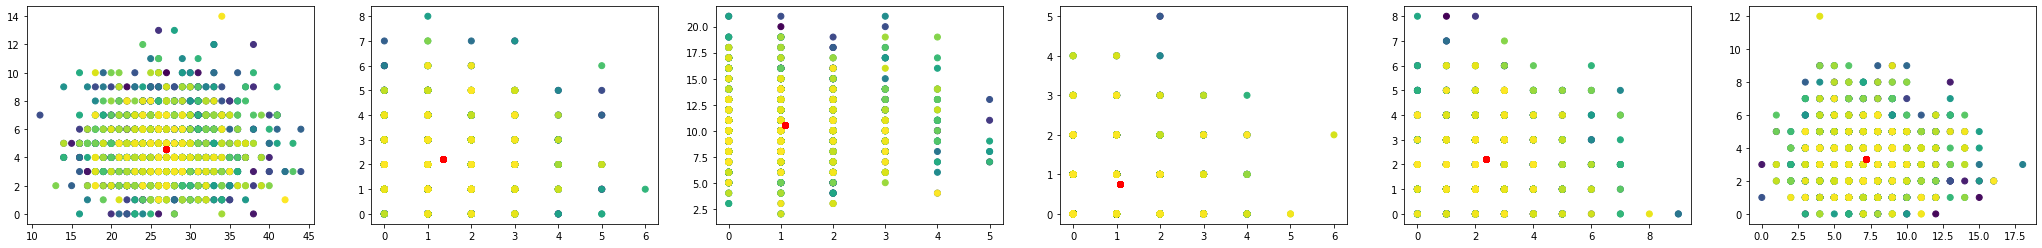

In [13]:
n=1500
t=np.linspace(0,1,n)
r=0.002
tau=(0,0.5,1)
K=2
loga_max=4
logb_max=2
p = int(2*n*r) 
true_p=0

np.random.seed(42)
theta=np.zeros((p,K+4))
theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,1]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-4]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-2]=np.exp(np.random.uniform(0,logb_max,size=p))
theta[:,-1]=np.exp(np.random.uniform(0,logb_max,size=p))
theta[true_p:,-2]=1
theta[true_p:,-1]=theta[true_p:,-4]/theta[true_p:,-3]
theta[true_p:,0]=theta[true_p:,-4]
theta[true_p:,1]=theta[true_p:,-4]


Y = get_Y(theta,t,tau)
X = np.random.poisson(Y)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c=t);
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='r');

### No penalty

In [44]:
with open('data/uninformative.pickle', 'rb') as f:
    data=pickle.load(f)
thetas, theta_hats, weights = data[0]
thetas_1, theta_hats_1, weights_1 = data[0.1]
thetas_2, theta_hats_2, weights_2 = data[0.01]
thetas_3, theta_hats_3, weights_3 = data[0.001]

In [100]:
thetas, theta_hats, weights = get_fit_result(n=1500, rs=[0.01, 1/30, 0.1], add_null=True, seeds=[42,63], cores=20)

100%|██████████| 20/20 [08:04<00:00, 24.24s/it]


**plot uninformative genes**

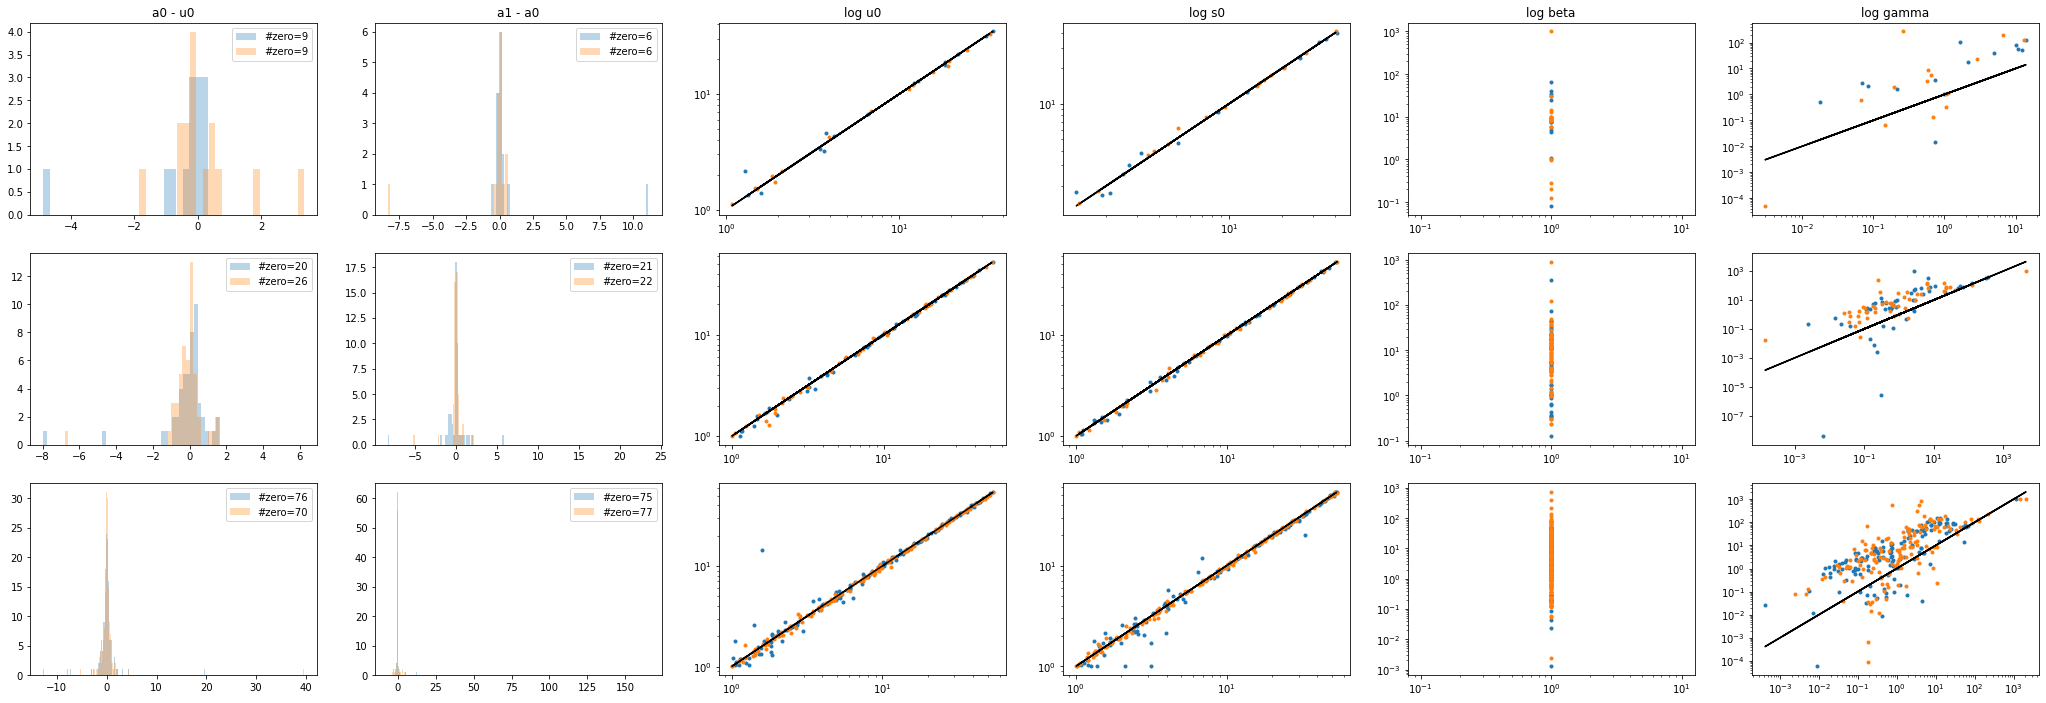

In [25]:
plot_uninformative_genes(thetas, theta_hats, weights)

**plot informative genes**

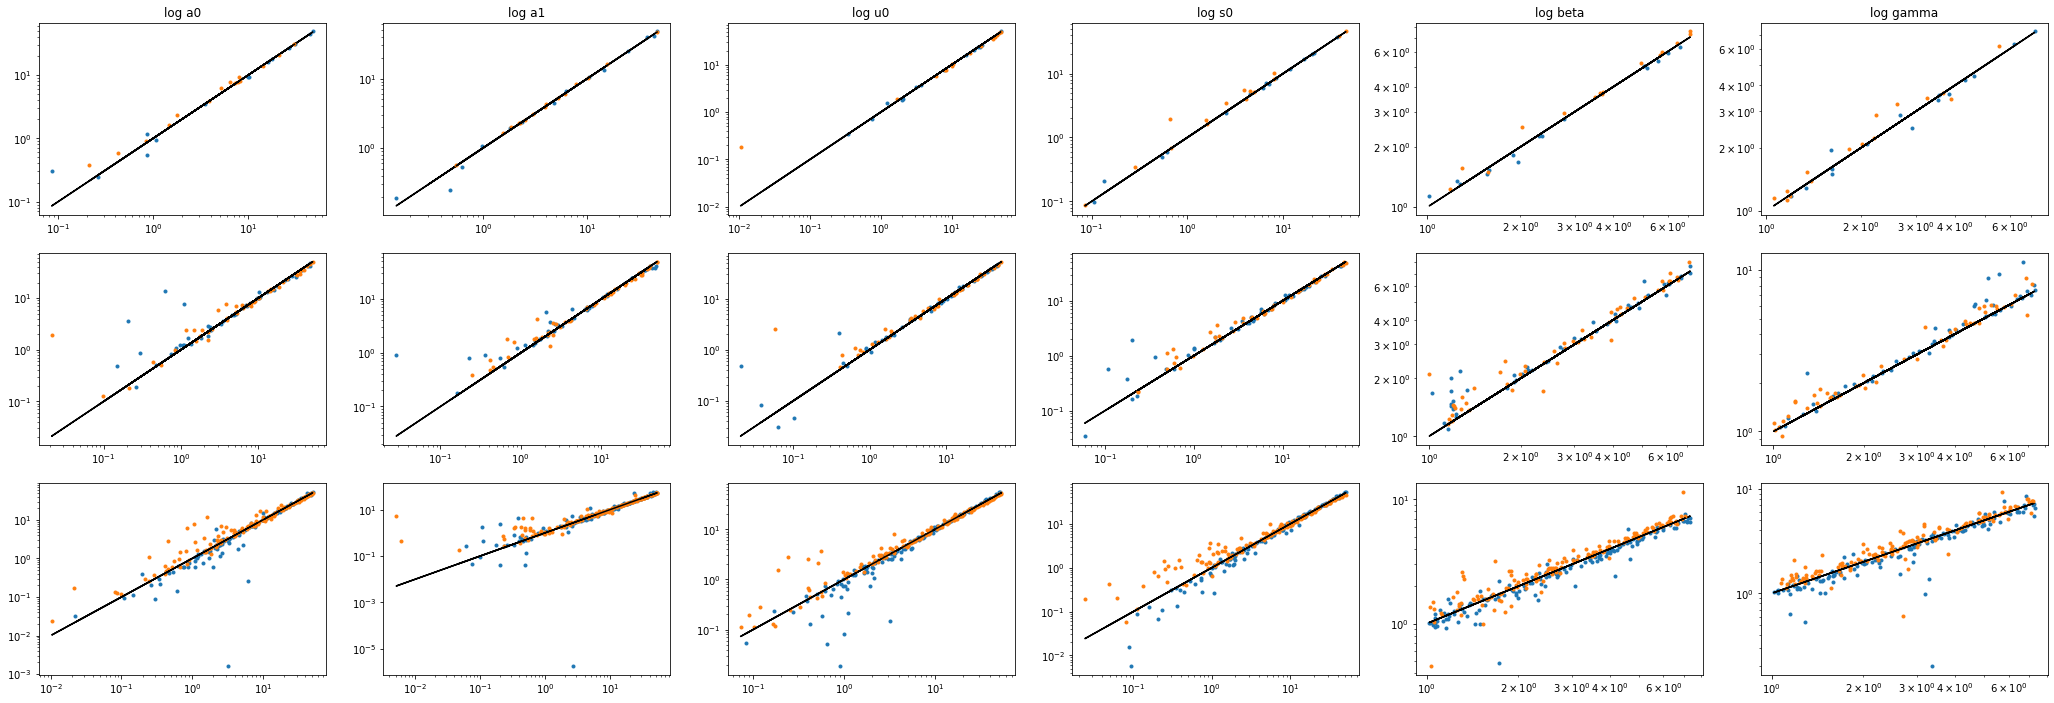

In [114]:
plot_informative_genes(thetas, theta_hats, weights)

### Penalty 0.0001

In [41]:
thetas_4, theta_hats_4, weights_4 = get_fit_result(relative_penalty=0.0001)

100%|██████████| 20/20 [14:21<00:00, 43.10s/it]


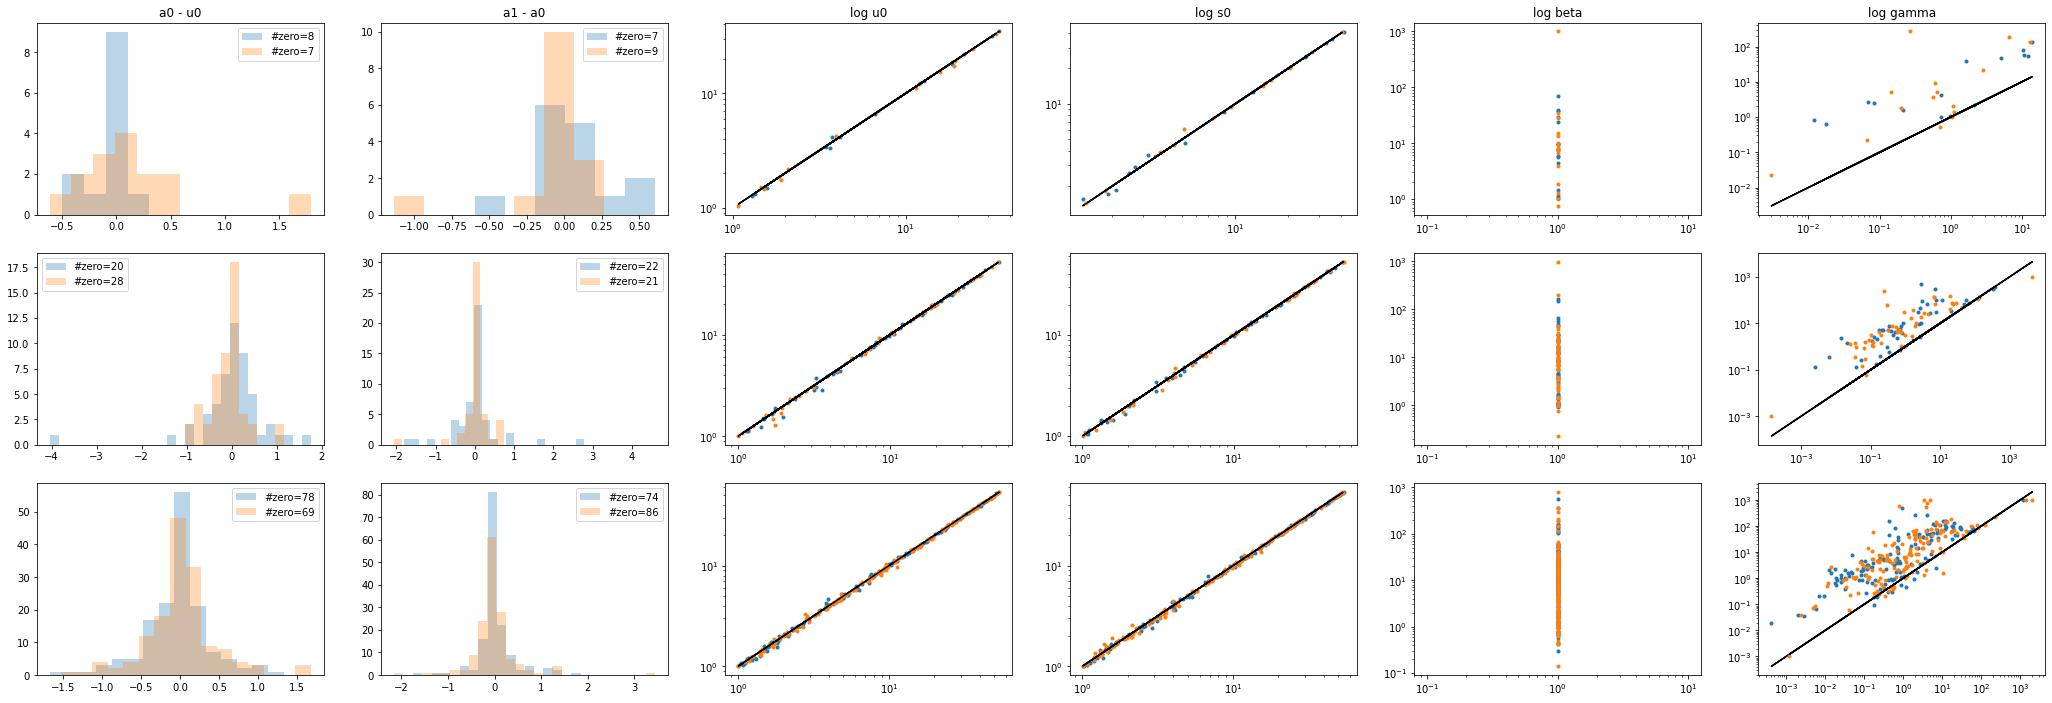

In [42]:
plot_uninformative_genes(thetas_4, theta_hats_4, weights_4)

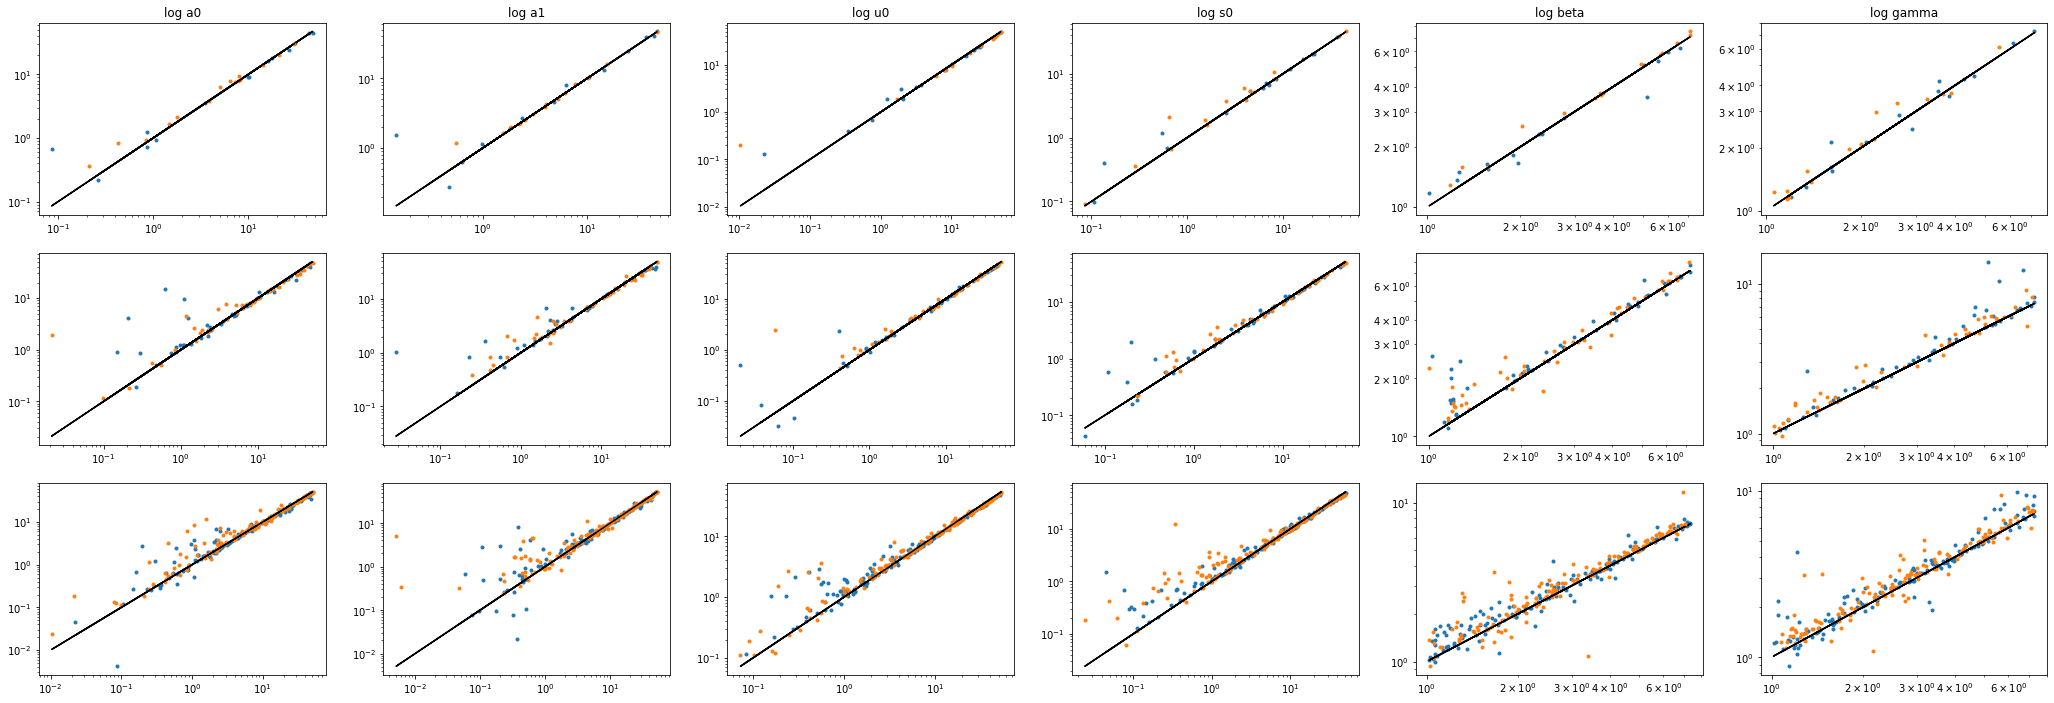

In [43]:
plot_informative_genes(thetas_4, theta_hats_4, weights_4)

### Penalty 0.001

In [117]:
thetas_3, theta_hats_3, weights_3 = get_fit_result(relative_penalty=0.001)

100%|██████████| 20/20 [10:05<00:00, 30.27s/it]


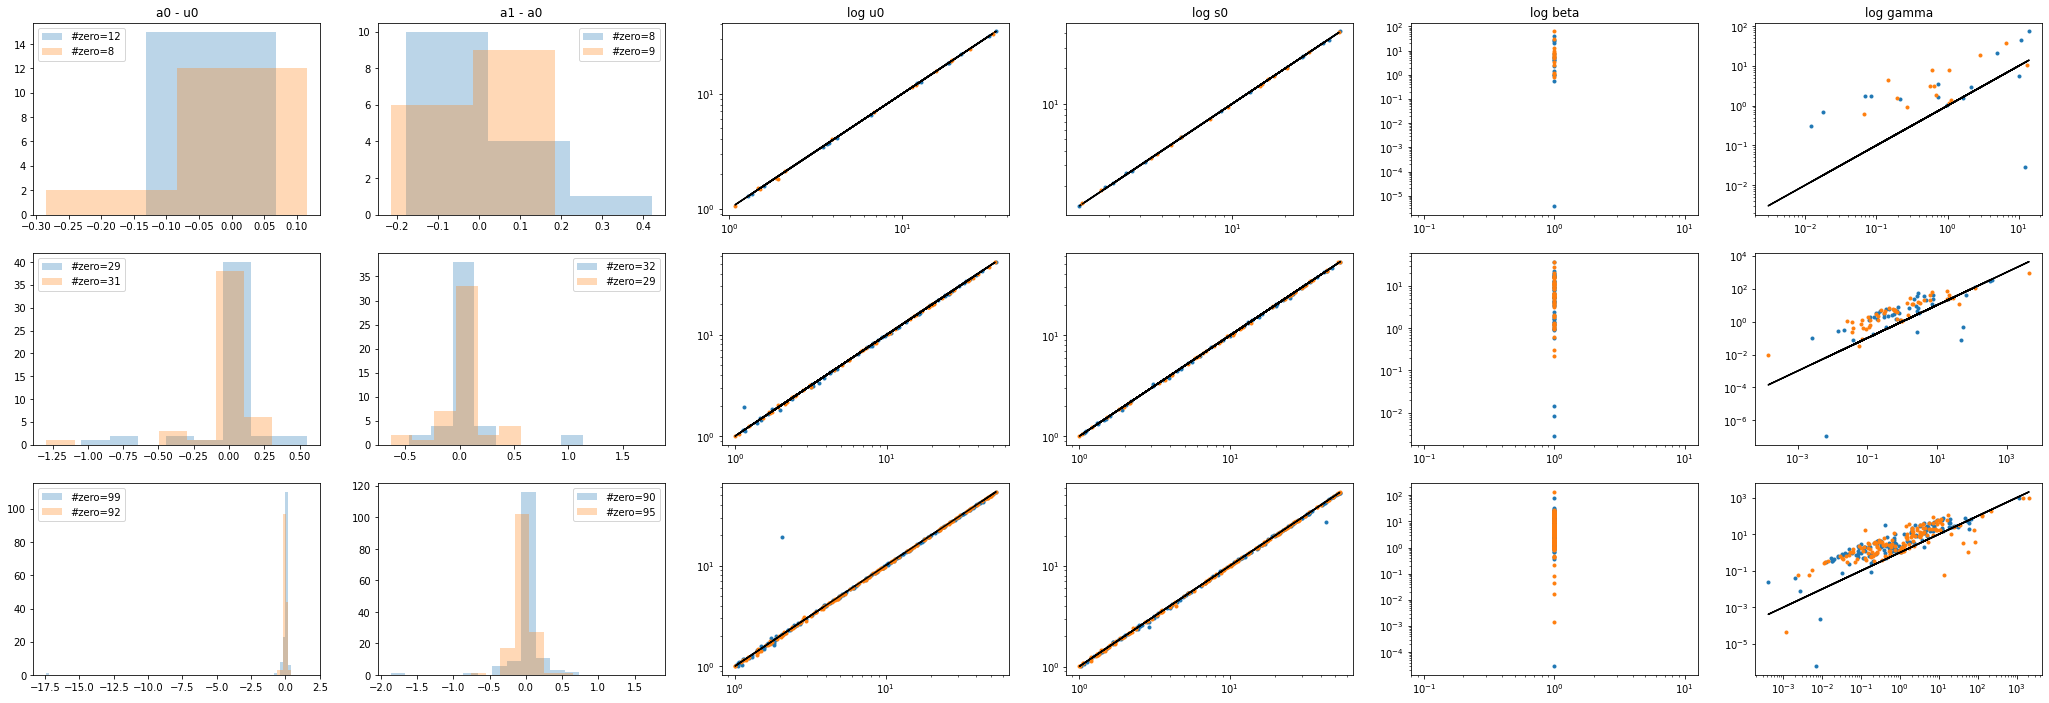

In [27]:
plot_uninformative_genes(thetas_3, theta_hats_3, weights_3)

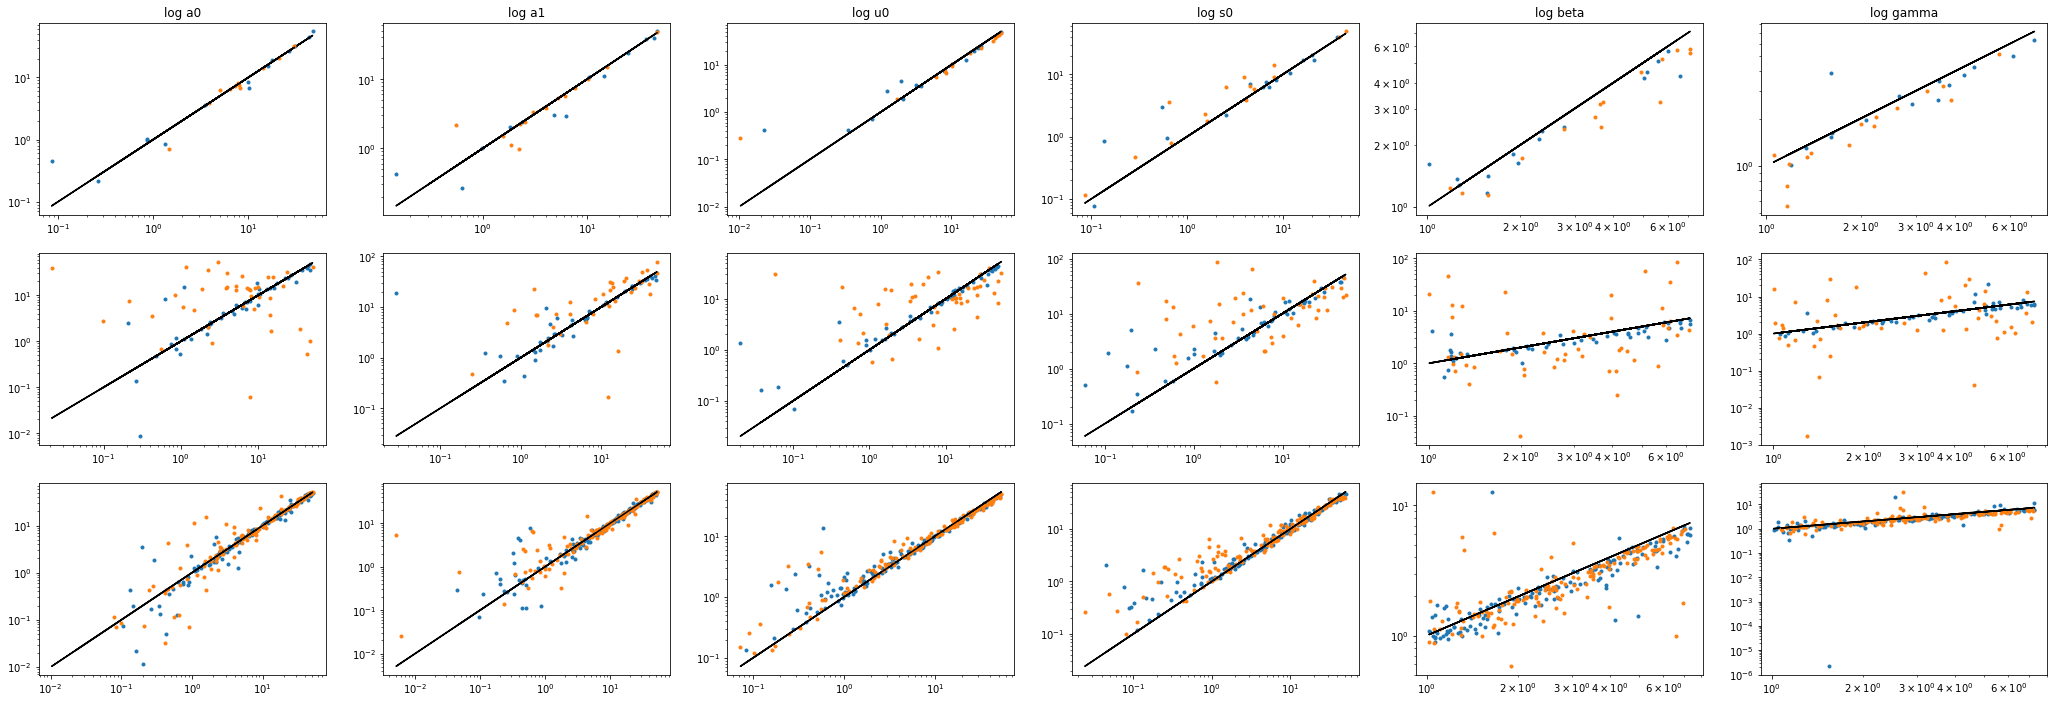

In [29]:
plot_informative_genes(thetas_3, theta_hats_3, weights_3)

### Penalty 0.01

In [118]:
thetas_2, theta_hats_2, weights_2 = get_fit_result(relative_penalty=0.01)

100%|██████████| 20/20 [13:02<00:00, 39.10s/it]


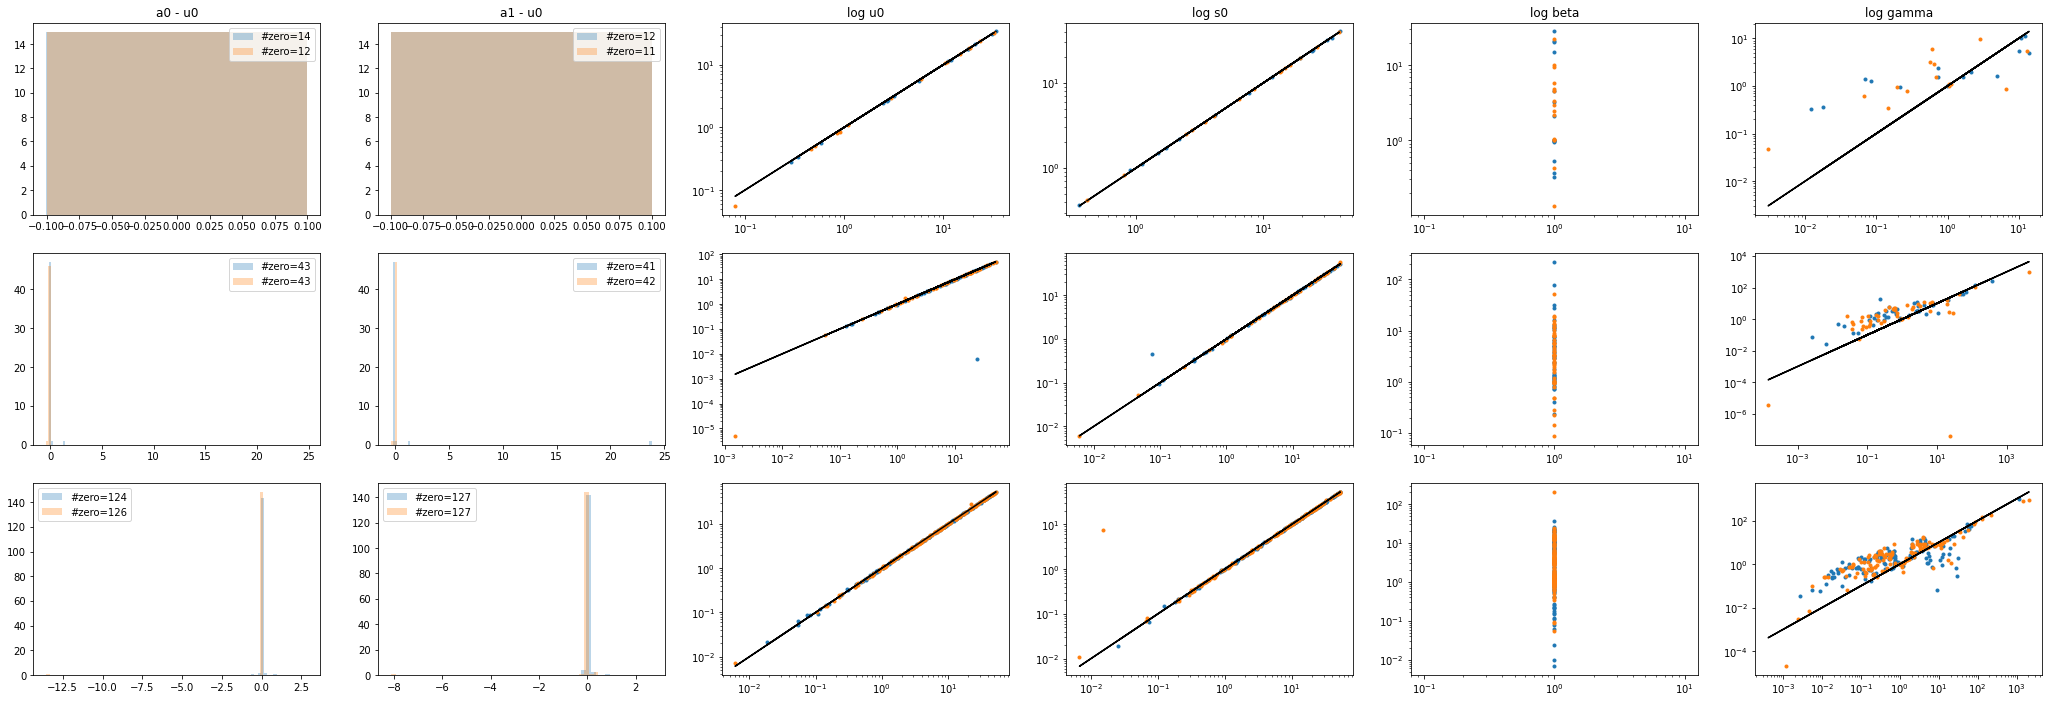

In [125]:
plot_uninformative_genes(thetas_2, theta_hats_2, weights_2)

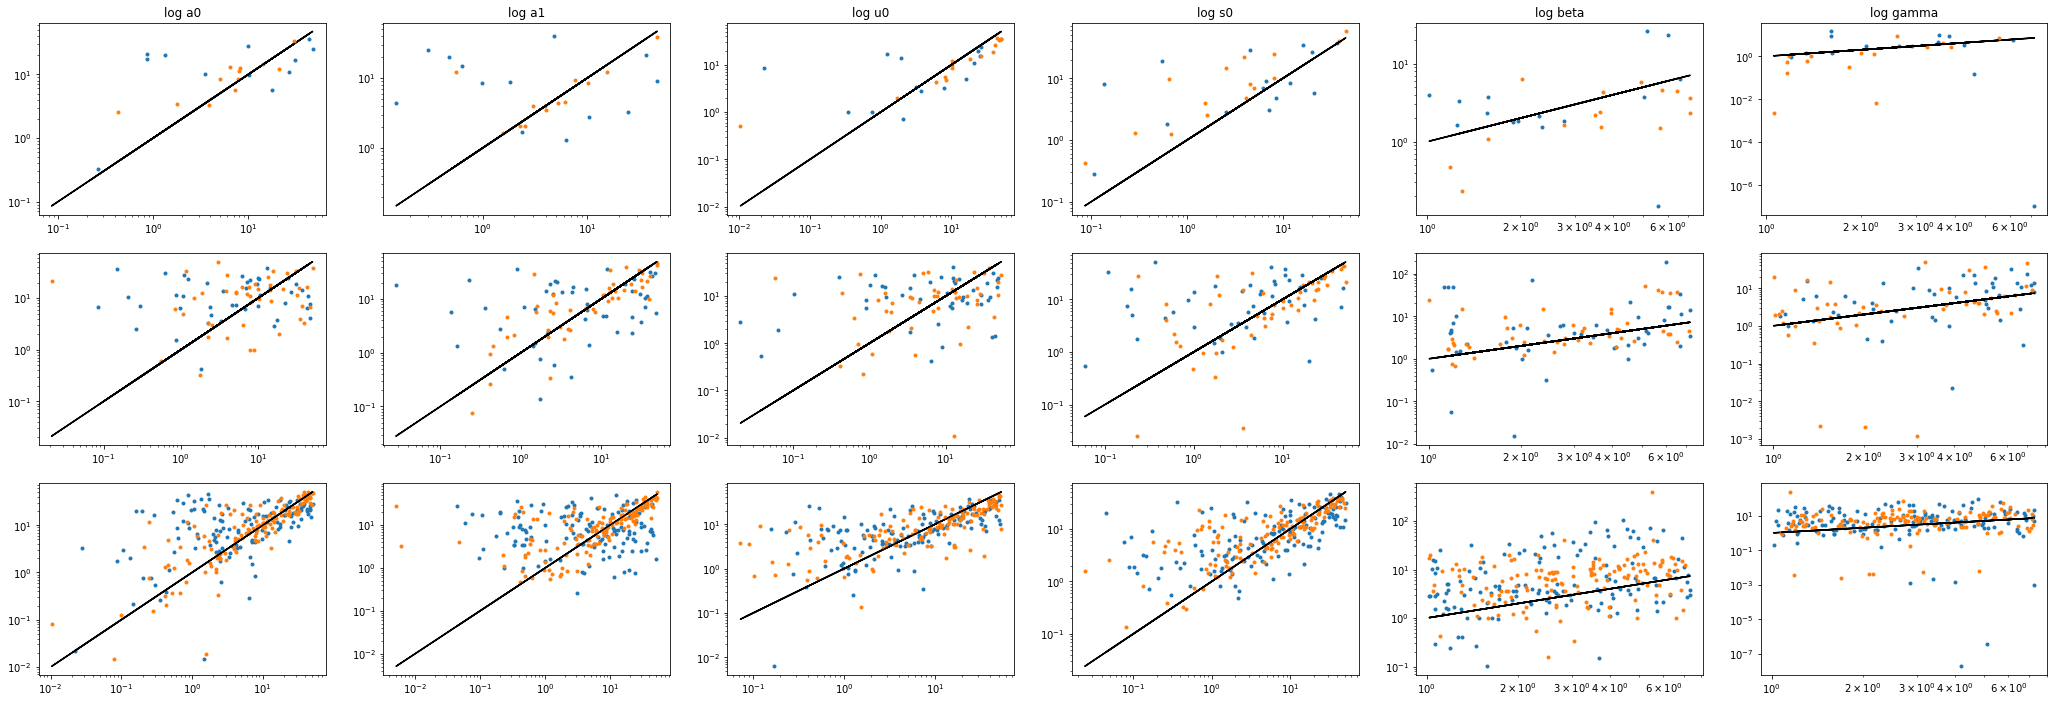

In [126]:
plot_informative_genes(thetas_2, theta_hats_2, weights_2)

### Penalty 0.1

In [119]:
thetas_1, theta_hats_1, weights_1 = get_fit_result(relative_penalty=0.1)

100%|██████████| 20/20 [12:20<00:00, 37.01s/it]


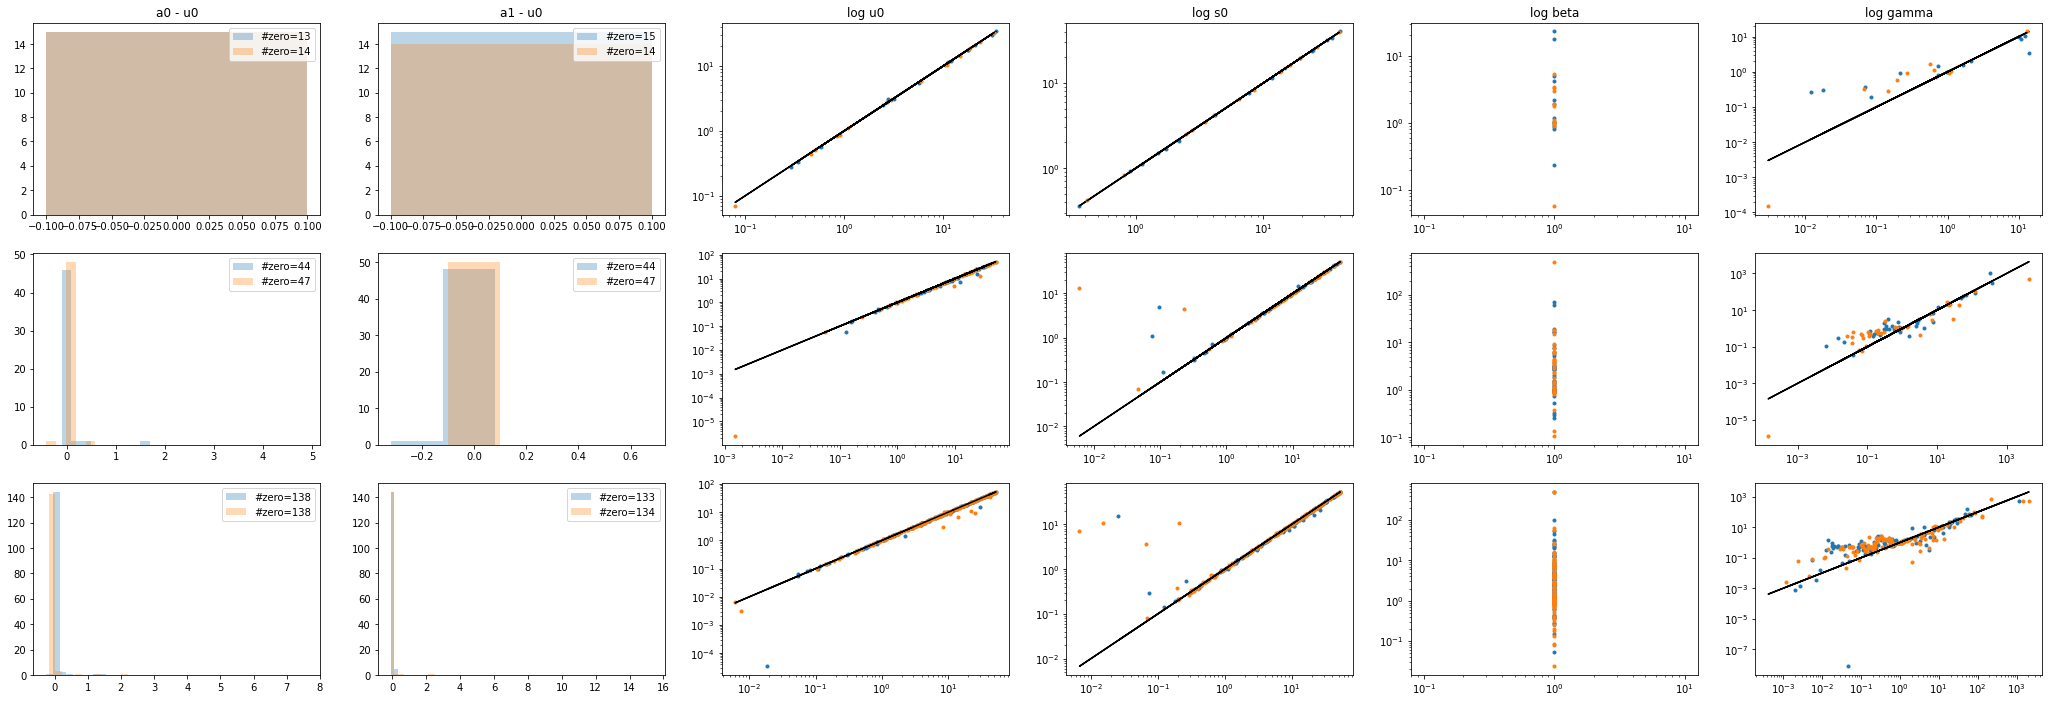

In [127]:
plot_uninformative_genes(thetas_1, theta_hats_1, weights_1)

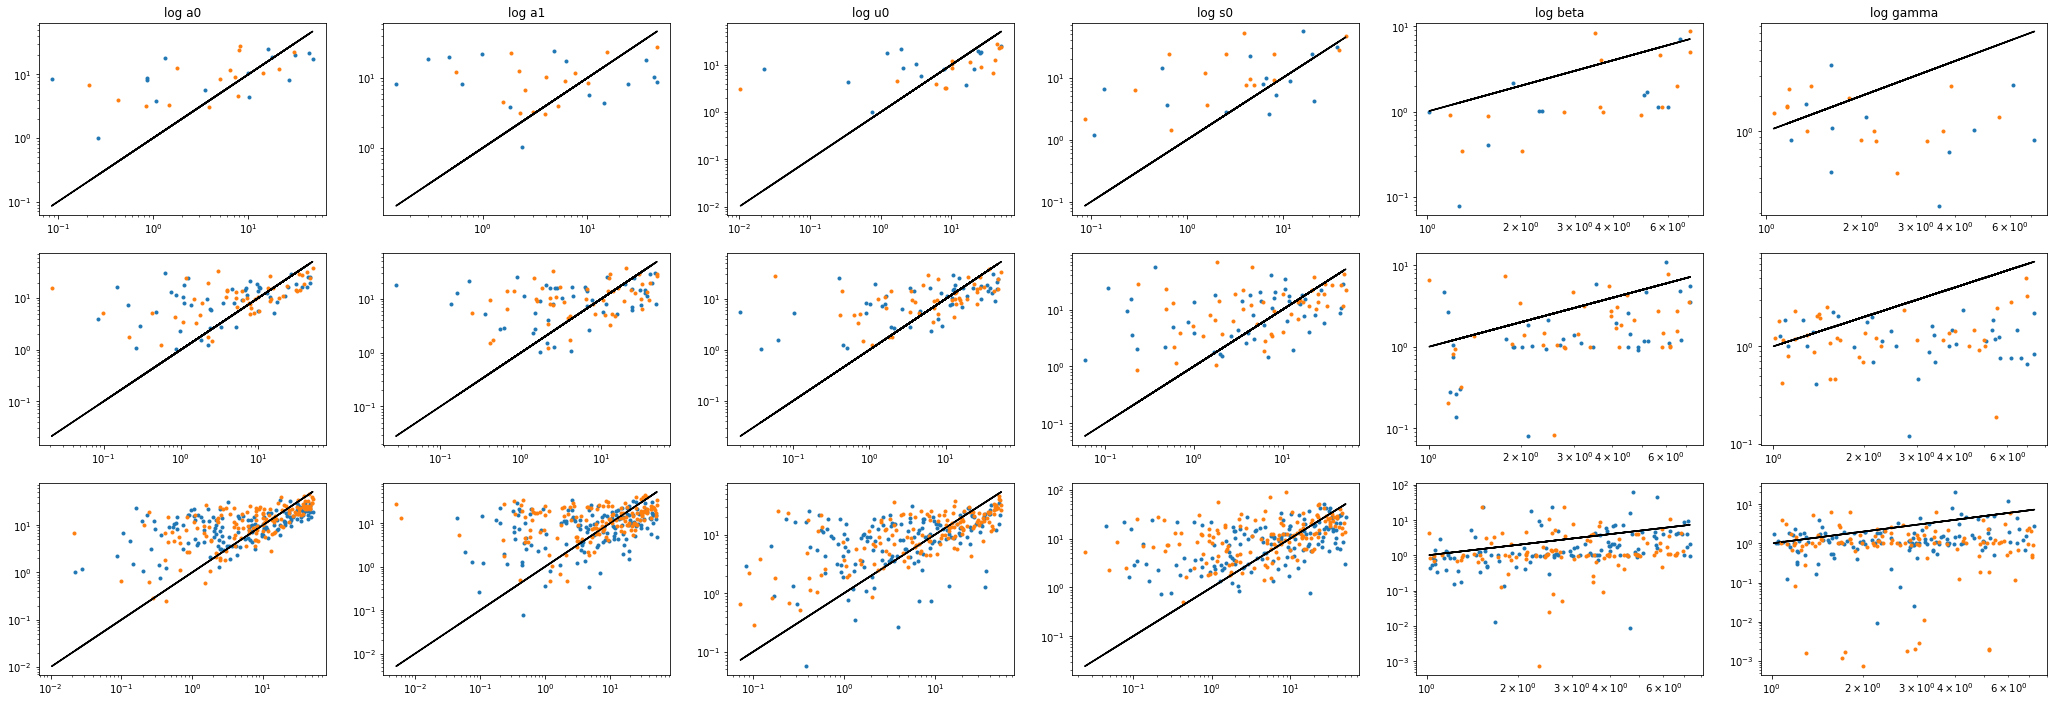

In [128]:
plot_informative_genes(thetas_1, theta_hats_1, weights_1)

### Pickle data

In [45]:
data = {0:(thetas, theta_hats, weights),0.1:(thetas_1, theta_hats_1, weights_1),0.01:(thetas_2, theta_hats_2, weights_2),0.001:(thetas_3, theta_hats_3, weights_3),0.0001:(thetas_4, theta_hats_4, weights_4)}
with open('data/uninformative.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)